In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


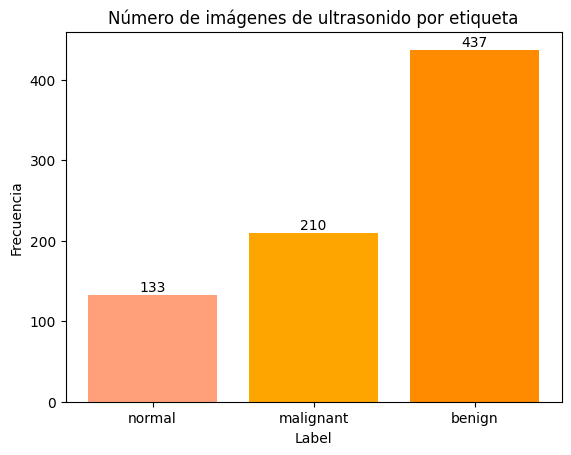

<built-in method items of dict object at 0x7924bd24f840>


In [ ]:
## Avance 1 de proyecto
## Título: Comparación de algoritmos de segmentación para la detección de cáncer de mama a partir de imágenes de ultrasonido
## Autores: Alessandra Mercedes Aldave Javier, Valeria Oriana Zavaleta Jave


# Importación de librerías
import os
import glob
import matplotlib.pyplot as plt
from collections import Counter
import cv2
import random
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


#Paths en google drive
normal_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal"
malignant_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant"
benign_path = "/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign"


# Paths de la ubicación de cada carpeta de datos
#normal_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Avance1\Dataset_BUSI_with_GT\normal"
#malignant_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Avance1\Dataset_BUSI_with_GT\malignant"
#benign_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Avance1\Dataset_BUSI_with_GT\benign"


# Función para cargar dataset de imágenes
    # Se usara un diccionario para guardar el path correspondiente a una imagen x (como key), y como value se tendra una lista cuyos elementos son: la etiqueta de esa imagen x, y el path de la mascara de la imagen x (lo mismo para todas las imagenes)
def CargarImagenesYMascaras(path_de_file):
    dataset = {} # Creación del diccionario
    for path_de_imagen in glob.glob(os.path.join(path_de_file, '*.png')):
        filename = os.path.basename(path_de_imagen)
        label = filename.split('(')[0].strip()
        if "_mask" not in filename:
            mask_path = os.path.join(path_de_file, filename.replace('.png', '_mask.png'))
            if os.path.exists(mask_path):
                dataset[path_de_imagen] = [label, mask_path]
    return dataset

# Cargar paths de imágenes de ultrasonido con su respectivo label y path de imagenes de mascaras
dataset = {}
dataset.update(CargarImagenesYMascaras(normal_path))
dataset.update(CargarImagenesYMascaras(malignant_path))
dataset.update(CargarImagenesYMascaras(benign_path))

# Determinación de la cantidad de imagenes de ultrasonido de cada tipo (o de cada label)
diccionario_conteo_labels = Counter(label for label,_ in dataset.values())

# Gráfico de barras
barras = plt.bar(diccionario_conteo_labels.keys(), diccionario_conteo_labels.values(), color= ['#FFA07A', '#FFA500', '#FF8C00'])
plt.xlabel('Label')
plt.ylabel('Frecuencia')
plt.title('Número de imágenes de ultrasonido por etiqueta')

for barra_label in barras:
    altura = barra_label.get_height()
    plt.text(barra_label.get_x() + barra_label.get_width() / 2, altura, altura, ha='center', va='bottom')

plt.show()
print(dataset.items)

In [ ]:
def dividir_dataset_por_clase(dataset, train_ratio=0.75):
    train_set = {}
    test_set = {}

    # Separar por clases
    clases = {'normal': [], 'benign': [], 'malignant': []}
    for path, (label, mask_path) in dataset.items():
        clases[label].append((path, (label, mask_path)))

    # Dividir cada clase
    for label, items in clases.items():
        random.shuffle(items)
        train_size = int(len(items) * train_ratio)
        train_items = items[:train_size]
        test_items = items[train_size:]

        # Añadir al conjunto de entrenamiento y prueba
        train_set.update(train_items)
        test_set.update(test_items)

    return train_set, test_set

# Aplicar la función para dividir el dataset
train_set, test_set = dividir_dataset_por_clase(dataset)

Imágenes de ultrasonido normales:
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (9).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (127).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/normal/normal (23).png


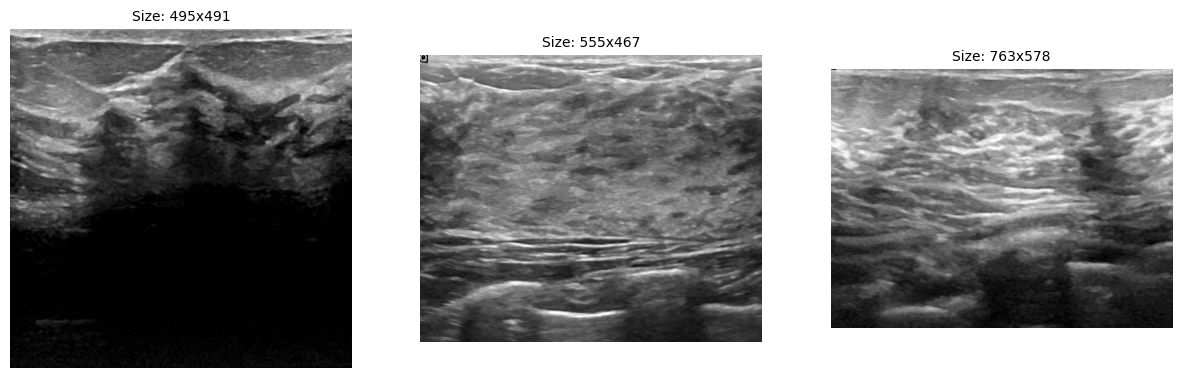


Imágenes de ultrasonido benignas:
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (203).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (239).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/benign/benign (66).png


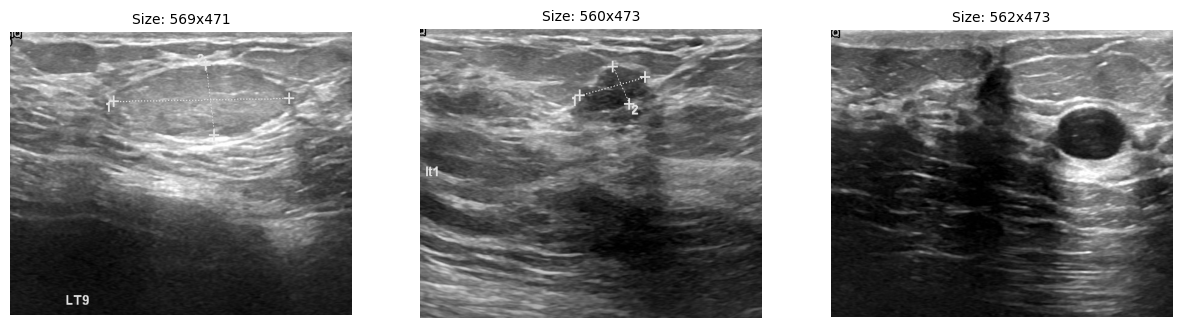


Imágenes de ultrasonido malignas:
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (125).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (119).png
/content/drive/My Drive/Reconocimiento de Patrones - Proyecto/Dataset_BUSI_with_GT/malignant/malignant (53).png


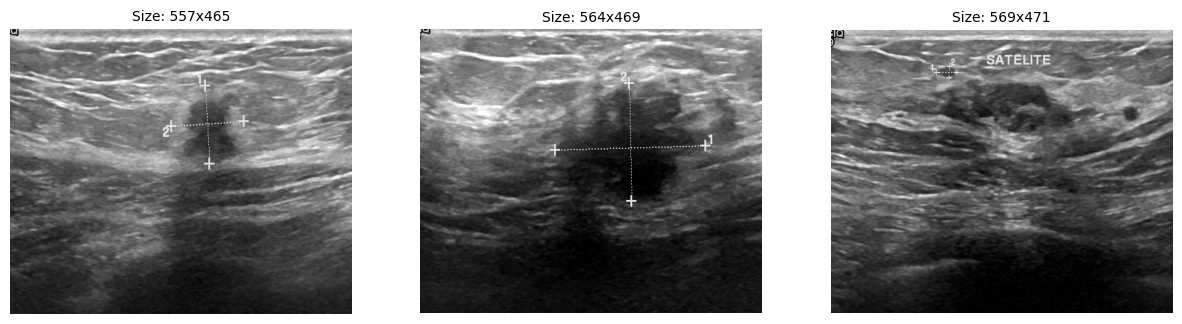

In [ ]:
# Muestra de las primeras tres images de cada etiqueta del dataset
def Mostrar3Imagenes(image_paths):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        if i < len(axes):
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i].imshow(image_rgb)
            axes[i].axis('off')

            # Características de la imagen
            propiedades_imagenes = f"Size: {image.shape[1]}x{image.shape[0]}"
            axes[i].set_title(propiedades_imagenes, fontsize=10)

            # Path de las imagenes
            print(image_path)
    plt.show()

# Seleccion de 3 imagenes de cada categoria sin tomar en cuenta las mascaras
normal_images = random.sample([path for path, (label, _) in dataset.items() if label == 'normal'], 3)
benign_images = random.sample([path for path, (label, _) in dataset.items() if label == 'benign'], 3)
malignant_images = random.sample([path for path, (label, _) in dataset.items() if label == 'malignant'], 3)

print("Imágenes de ultrasonido normales:")
Mostrar3Imagenes(normal_images)
print("\nImágenes de ultrasonido benignas:")
Mostrar3Imagenes(benign_images)
print("\nImágenes de ultrasonido malignas:")
Mostrar3Imagenes(malignant_images)

In [ ]:
# Transformaciones de Augmentations
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, Perspective, Resize
from albumentations.pytorch import ToTensorV2

In [ ]:
class UltrasoundDataset(Dataset):
    def __init__(self, dataset, transform=None,target_size=(224, 224)):
        self.dataset = list(dataset.items())
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, (label, mask_path) = self.dataset[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        #image = np.expand_dims(image, axis=0)  # Añadir el canal
        #mask = np.expand_dims(mask, axis=0)  # Añadir el canal

        return image, mask

In [ ]:
train_transform = Compose([
    Resize(224, 224),  #
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=15, p=0.5),
    Perspective(scale=(0.05, 0.1), keep_size=True, p=0.5),
    ToTensorV2()
])

test_transform = Compose([
    Resize(224, 224),  #
    ToTensorV2()
])

train_dataset = UltrasoundDataset(train_set, transform=train_transform)
test_dataset = UltrasoundDataset(test_set, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
import torch.nn as nn
import torch

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_channels=1, num_classes=1):
        super(UNet, self).__init__()
        num_feat = [32, 64, 128, 256, 512]

        self.down1 = nn.Sequential(Conv3x3(num_channels, num_feat[0]))
        self.down2 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[0], num_feat[1]))
        self.down3 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[1], num_feat[2]))
        self.down4 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[2], num_feat[3]))
        self.bottom = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                    Conv3x3(num_feat[3], num_feat[4]))
        self.up1 = UpConcat(num_feat[4], num_feat[3])
        self.upconv1 = Conv3x3(num_feat[4], num_feat[3])
        self.up2 = UpConcat(num_feat[3], num_feat[2])
        self.upconv2 = Conv3x3(num_feat[3], num_feat[2])
        self.up3 = UpConcat(num_feat[2], num_feat[1])
        self.upconv3 = Conv3x3(num_feat[2], num_feat[1])
        self.up4 = UpConcat(num_feat[1], num_feat[0])
        self.upconv4 = Conv3x3(num_feat[1], num_feat[0])
        self.final = nn.Sequential(nn.Conv2d(num_feat[0], num_classes, kernel_size=1), nn.Sigmoid())

    def forward(self, inputs):
        down1_feat = self.down1(inputs)
        down2_feat = self.down2(down1_feat)
        down3_feat = self.down3(down2_feat)
        down4_feat = self.down4(down3_feat)
        bottom_feat = self.bottom(down4_feat)
        up1_feat = self.up1(bottom_feat, down4_feat)
        up1_feat = self.upconv1(up1_feat)
        up2_feat = self.up2(up1_feat, down3_feat)
        up2_feat = self.upconv2(up2_feat)
        up3_feat = self.up3(up2_feat, down2_feat)
        up3_feat = self.upconv3(up3_feat)
        up4_feat = self.up4(up3_feat, down1_feat)
        up4_feat = self.upconv4(up4_feat)
        outputs = self.final(up4_feat)
        return outputs

In [ ]:
class Conv3x3(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Conv3x3, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_feat, out_feat, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(out_feat), nn.ReLU(),
                                   nn.Dropout(p=0.3))
        self.conv2 = nn.Sequential(nn.Conv2d(out_feat, out_feat, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(out_feat), nn.ReLU(),
                                   nn.Dropout(p=0.3))
    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs

In [ ]:
class UpConcat(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(UpConcat, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_feat, out_feat, kernel_size=2, stride=2)
    def forward(self, inputs, down_outputs):
        outputs = self.deconv(inputs)
        out = torch.cat([down_outputs, outputs], 1)
        return out

In [ ]:
# Definición del modelo, pérdida y optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(num_channels=1, num_classes=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
import time

In [ ]:
# Función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss = 0
        batch_count = len(train_loader)

        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            masks = masks.unsqueeze(1)  # Agrego una dimensión en el índice 1 para representar el canal

            # Normalizo la máscara para asegurarme de que los valores estén en el rango [0, 1]
            masks = masks / 255.0
            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{batch_count}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Time: {epoch_end_time - epoch_start_time:.2f}s')


In [ ]:
# Entrenamiento del modelo
num_epochs = 5  # Defino el número de épocas
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/5], Batch [1/73], Loss: 0.7591
Epoch [1/5], Batch [11/73], Loss: 0.6063
Epoch [1/5], Batch [21/73], Loss: 0.5281
Epoch [1/5], Batch [31/73], Loss: 0.5054
Epoch [1/5], Batch [41/73], Loss: 0.4398
Epoch [1/5], Batch [51/73], Loss: 0.4449
Epoch [1/5], Batch [61/73], Loss: 0.3785
Epoch [1/5], Batch [71/73], Loss: 0.3901
Epoch [1/5], Loss: 0.5124, Time: 1211.49s
Epoch [2/5], Batch [1/73], Loss: 0.3543
Epoch [2/5], Batch [11/73], Loss: 0.4292
Epoch [2/5], Batch [21/73], Loss: 0.4014
Epoch [2/5], Batch [31/73], Loss: 0.3350
Epoch [2/5], Batch [41/73], Loss: 0.3868
Epoch [2/5], Batch [51/73], Loss: 0.3149
